# Bidirectional Long Short-Term Memory (BiLSTM) 

It is a neural network model for sentiment analysis. The key components of the BiLSTM model include:

- An embedding layer that converts tokenized text into dense vectors
- A SpatialDropout1D layer to help prevent overfitting
- A Bidirectional LSTM layer that processes the sequence in both forward and backward directions
- A GlobalMaxPooling1D layer to capture the most important features from the BiLSTM output
- Dense layers with ReLU activation for deeper representation learning
- A final softmax layer for 3-class classification (Negative, Neutral, Positive)

I streamlined it by using only one BiLSTM layer instead of two stacked ones, and incorporated more modern practices like spatial dropout and global pooling for improved efficiency and performance.

In [123]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import pickle

In [73]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
os.makedirs("outputs", exist_ok=True)

In [77]:
df = pd.read_csv("Instruments_Reviews.csv")
df = df.dropna(subset=['reviewText'])

# Map ratings to 3 classes 
def label_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['overall'].apply(label_sentiment)

# Print class distribution
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
print(f"Class distribution: {sentiment_counts.to_dict()}")

texts = df['reviewText'].values
labels = df['sentiment'].astype(int).values

Class distribution: {2: 87.91691047396138, 1: 7.528769260776283, 0: 4.554320265262337}


In [79]:
# Tokenization with optimized settings
vocab_size = 15000  # Reduced from 20000 to focus on more important words
max_length = 150    # Reduced from 200 based on common review lengths
print(f"Tokenizing text with vocab size: {vocab_size}, max length: {max_length}")

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')

Tokenizing text with vocab size: 15000, max length: 150


In [81]:
# Save tokenizer
with open("outputs/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved to: outputs/tokenizer.pkl")

✅ Tokenizer saved to: outputs/tokenizer.pkl


In [83]:
# Train-test-validation split (added explicit validation set)
X_train, X_temp, y_train, y_temp = train_test_split(padded, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 7177 samples
Validation set: 1538 samples
Test set: 1539 samples


In [85]:
# Calculate class weights to handle imbalance
class_weights = {}
total = len(y_train)
for i in range(3):
    class_weights[i] = total / (np.sum(y_train == i) * 3)
print(f"Class weights: {class_weights}")

Class weights: {0: 7.316004077471967, 1: 4.4302469135802465, 2: 0.37913365029054413}


In [87]:
# Optimize model architecture
embedding_dim = 100  # Reduced from 128 for efficiency

model = Sequential([
    # Input layer
    Embedding(vocab_size, embedding_dim, mask_zero=False),  # Disabled mask_zero for performance
    
    # Spatial dropout helps prevent overfitting in text data better than regular dropout
    SpatialDropout1D(0.2),
    
    # First BiLSTM layer with optimized units
    Bidirectional(LSTM(50, return_sequences=True)),
    
    # Global max pooling captures the most important features
    GlobalMaxPooling1D(),
    
    # Dense layers with batch normalization
    Dense(50, activation='relu'),
    Dropout(0.3),
    
    # Output layer
    Dense(3, activation='softmax')
])

In [118]:
# Use Adam optimizer with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [91]:
# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='outputs/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [93]:
# Train with explicit validation set and callbacks
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,  # Increased from 64 for faster training
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Training model...
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3045 - loss: 1.1084
Epoch 1: val_loss improved from inf to 1.06282, saving model to outputs/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.3064 - loss: 1.1082 - val_accuracy: 0.6827 - val_loss: 1.0628
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5044 - loss: 1.0633
Epoch 2: val_loss improved from 1.06282 to 0.91540, saving model to outputs/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.5063 - loss: 1.0627 - val_accuracy: 0.7549 - val_loss: 0.9154
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7542 - loss: 0.8742
Epoch 3: val_loss improved from 0.91540 to 0.62141, saving model to outputs/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.7545 - loss: 0.8734 - val_accuracy: 0.7614 - val_loss: 0.6214
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8058 - loss: 0.6503
Epoch 4: 

In [94]:
# Save the final model
model.save("outputs/sentiment_bilstm_model_3class.keras")
print("✅ Model saved to: outputs/sentiment_bilstm_model_3class.keras")

✅ Model saved to: outputs/sentiment_bilstm_model_3class.keras


In [96]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8187


In [100]:
# Predict probabilities and class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:")
report = classification_report(
    y_test, 
    y_pred, 
    target_names=['Negative', 'Neutral', 'Positive'],
    output_dict=True
)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.13      0.19        70
     Neutral       0.22      0.41      0.29       116
    Positive       0.93      0.89      0.91      1353

    accuracy                           0.82      1539
   macro avg       0.51      0.48      0.46      1539
weighted avg       0.85      0.82      0.83      1539



In [102]:
# Save report to CSV
pd.DataFrame(report).transpose().to_csv('outputs/classification_report.csv')

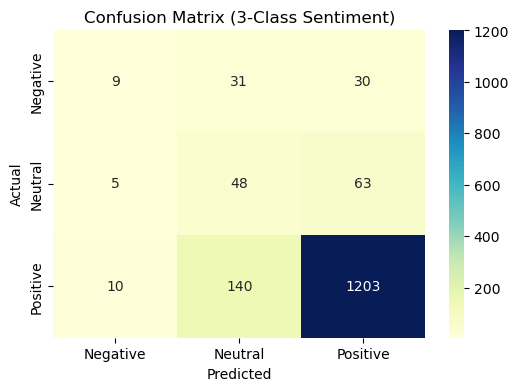

In [114]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu', 
    xticklabels=['Negative', 'Neutral', 'Positive'], 
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (3-Class Sentiment)")
plt.savefig('outputs/confusion_matrix.png')

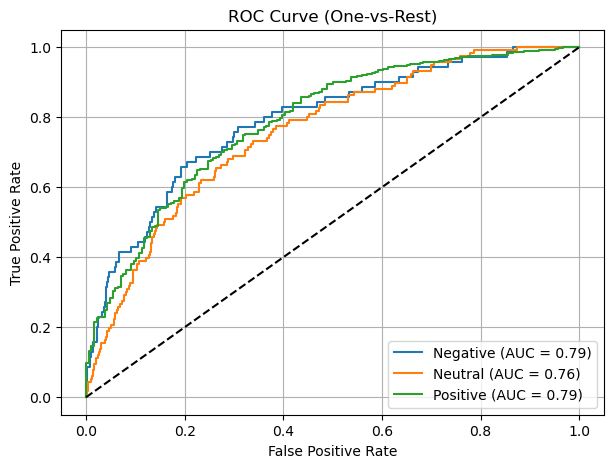

In [112]:
# ROC-AUC for Multi-Class (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}
plt.figure(figsize=(7, 5))
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc='lower right')
plt.grid()
plt.savefig('outputs/roc_curve.png')
plt.show()
plt.close()

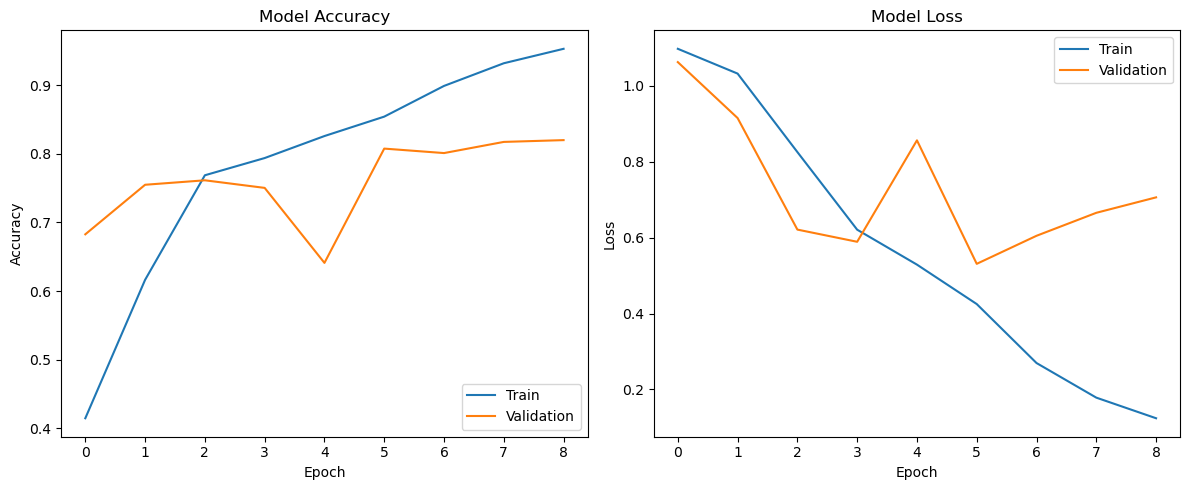

In [116]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('outputs/training_history.png')

# BERT Transformer Model

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

In [9]:
df = pd.read_csv("Instruments_Reviews.csv")
df['reviews'] = df['reviewText'] + " " + df['summary']
df['reviews'] = df['reviews'].fillna('')


In [10]:
def Labelling(row):
    text = row['reviews']
    
    # Handle missing or non-string entries
    if not isinstance(text, str):
        return 'Neutral'  # or anything you prefer as default

    text = text.lower()
    
    if any(word in text for word in ['bad', 'terrible', 'worst', 'awful', 'poor']):
        return 'Negative'
    elif any(word in text for word in ['okay', 'average', 'fine', 'decent']):
        return 'Neutral'
    elif any(word in text for word in ['good', 'great', 'excellent', 'amazing', 'perfect']):
        return 'Positive'
    else:
        return 'Neutral'  # fallback


In [11]:
df['sentiment'] = df.apply(Labelling, axis=1)

# Map sentiments to numerical values
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment_num'] = df['sentiment'].map(sentiment_mapping)

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['reviews'], 
    df['sentiment_num'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_num']
)

In [13]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\dprsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dprsh\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\Users\dprsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Tokenize and encode the sequences
def encode_texts(texts, max_len=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


In [15]:
# Encode training and validation data
train_inputs, train_masks = encode_texts(X_train.tolist())
val_inputs, val_masks = encode_texts(X_test.tolist())

C:\Users\dprsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_test.values)

In [17]:
# Create DataLoader
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3, # Negative, Neutral, Positive
    output_attentions=False,
    output_hidden_states=False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

C:\Users\dprsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Training function
def train_model():
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        
        loss = outputs[0]
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

In [21]:
# Evaluation function
def evaluate_model():
    model.eval()
    predictions, true_labels = [], []
    total_loss = 0
    
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
        
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions.append(logits)
        true_labels.append(label_ids)
    
    avg_val_loss = total_loss / len(val_dataloader)
    print(f"Average validation loss: {avg_val_loss}")
    
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    pred_labels = np.argmax(predictions, axis=1)
    
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive']))
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    
    return avg_val_loss

In [ ]:
# Train and evaluate
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_model()
    evaluate_model()

Epoch 1/3


Training:   0%|                                                                                | 0/513 [00:00<?, ?it/s]

In [ ]:
# Save the model
model.save_pretrained('./bert_sentiment_model')
tokenizer.save_pretrained('./bert_sentiment_model')

In [ ]:
# Function to predict sentiment for new reviews
def predict_sentiment(text):
    model.eval()
    
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_id = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    pred_label = np.argmax(logits, axis=1).flatten()[0]
    
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_labels[pred_label]

In [ ]:
# Example usage
sample_review = "This product is amazing! Works perfectly and exceeded my expectations."
print(predict_sentiment(sample_review))